# Weapon Damage by Target

## Setting Up

In [1]:
import pandas as pd
from weapon import max_shots, burst

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

We will use an average Accuracy of 50. Meaning the soldier fails half of the time.

The chance of hit formula is simple. Just multiply the soldier's accuracy chance by the weapon's accuracy chance. So an average of 50 to a weapon of Accuracy 90 means 0.50 * 0.9 = 0.45 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.50, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.325
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.410
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.410
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.410
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.160


## Derived Damage

In [4]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["expected_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["chance_to_hit"], axis=1)
weapon_attacks["clip_damage"] = weapon_attacks.apply(lambda x: x["capacity"] * x["damage"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.325,1,29.25,90.0,1,1.000000,90,29.25
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.410,1,17.22,588.0,1,14.000000,42,17.22
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.410,1,18.04,616.0,1,14.000000,44,18.04
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.410,1,19.68,672.0,1,14.000000,48,19.68
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.160,3,6.72,588.0,6,2.333333,252,40.32


## Damage to Target Type

### Data Merge

In [5]:
weapon_damages = weapon_attacks
weapon_damages = weapon_damages.append([weapon_damages] * (len(damage_modifiers.index)-1), ignore_index=True)
weapon_damages["key"] = weapon_damages.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

targets = damage_modifiers["target"]

weapon_damages = pd.merge(weapon_damages, targets, left_on="key", right_index=True, how="left", sort=False)
weapon_damages = weapon_damages.drop(columns=["key"])
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.325,1,29.250,90.0,1,1.000000,90,29.250,terrain
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.410,1,17.220,588.0,1,14.000000,42,17.220,terrain
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.410,1,18.040,616.0,1,14.000000,44,18.040,terrain
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.410,1,19.680,672.0,1,14.000000,48,19.680,terrain
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.160,3,6.720,588.0,6,2.333333,252,40.320,terrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.575,1,48.875,680.0,1,8.000000,85,48.875,zombie
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.275,1,23.375,680.0,2,4.000000,170,46.750,zombie
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.550,1,49.500,90.0,1,1.000000,90,49.500,zombie
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.325,1,29.250,90.0,2,0.500000,180,58.500,zombie


### Damage vs Type

In [6]:
def damage_modifier(group):
    """
    Returns the damage modifier for the weapon target.
    """
    target = damage_modifiers[damage_modifiers["target"] == group["target"]]
    damage = target[group["damage_type"]].values[0]
    return damage / 100

In [7]:
weapon_damages["target_damage"] = weapon_damages.apply(damage_modifier, axis=1)
weapon_damages["target_damage"] = weapon_damages.apply(lambda x: x["damage"] * damage_modifier(x), axis=1)
weapon_damages["target_expected_damage"] = weapon_damages.apply(lambda x: x["expected_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_clip_damage"] = weapon_damages.apply(lambda x: x["clip_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_max"] = weapon_damages.apply(lambda x: x["turn_damage_max"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_expected"] = weapon_damages.apply(lambda x: x["turn_damage_expected"] * damage_modifier(x), axis=1)
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,...,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target,target_damage,target_expected_damage,target_clip_damage,target_turn_damage_max,target_turn_damage_expected
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.325,...,1,1.000000,90,29.250,terrain,90.0,29.25,90.0,90.0,29.25
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.410,...,1,14.000000,42,17.220,terrain,42.0,17.22,588.0,42.0,17.22
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.410,...,1,14.000000,44,18.040,terrain,44.0,18.04,616.0,44.0,18.04
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.410,...,1,14.000000,48,19.680,terrain,48.0,19.68,672.0,48.0,19.68
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.160,...,6,2.333333,252,40.320,terrain,42.0,6.72,588.0,252.0,40.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.575,...,1,8.000000,85,48.875,zombie,68.0,39.10,544.0,68.0,39.10
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.275,...,2,4.000000,170,46.750,zombie,68.0,18.70,544.0,136.0,37.40
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.550,...,1,1.000000,90,49.500,zombie,0.0,0.00,0.0,0.0,0.00
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.325,...,2,0.500000,180,58.500,zombie,0.0,0.00,0.0,0.0,0.00


## Weapon Damages by Target

In [8]:
weapon_damages_targets = weapon_damages.groupby(["weapon", "target"]).max()
weapon_damages_targets = weapon_damages_targets[["target_turn_damage_expected"]]
weapon_damages_targets = weapon_damages_targets.rename(columns={"target_turn_damage_expected": "turn_damage"})
weapon_damages_targets = weapon_damages_targets.sort_values(by=["turn_damage"])
weapon_damages_targets

turn_damage
weapon         target                
stun_rod       zombie          0.0000
small_launcher zombie          0.0000
grenade        cyberdisk       9.7500
               tank           12.1875
               sectopod       13.0000
...                               ...
heavy_plasma   terrain       172.5000
               unarmored     172.5000
               ethereal      172.5000
               cyberdisk     172.5000
heavy_laser    sectopod      202.5000

[322 rows x 1 columns]

### Kinetic Weapons

Text(0, 0.5, 'Damage')

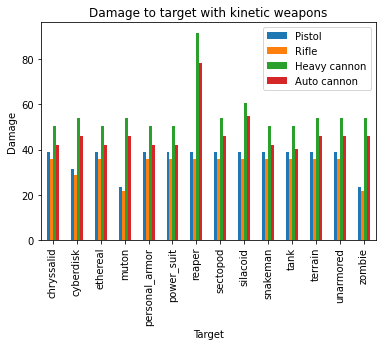

In [9]:
weapon_damages_targets_kinetic = weapon_damages_targets.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.swaplevel().unstack()
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.sort_values(by=["target"])
ax = weapon_damages_targets_kinetic.plot.bar(title="Damage to target with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Melee

Text(0, 0.5, 'Damage')

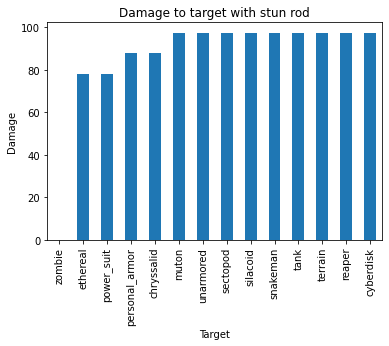

In [10]:
ax = weapon_damages_targets.loc[ "stun_rod" , : ].plot.bar(title="Damage to target with stun rod", legend=False)
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Explosive

Text(0, 0.5, 'Damage')

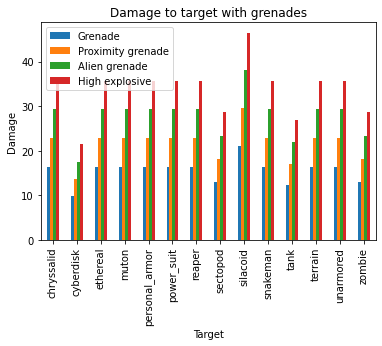

In [11]:
weapon_damages_targets_grenade = weapon_damages_targets.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_damages_targets_grenade = weapon_damages_targets_grenade.swaplevel().unstack()
weapon_damages_targets_grenade = weapon_damages_targets_grenade.sort_values(by=["target"])
ax = weapon_damages_targets_grenade.plot.bar(title="Damage to target with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

Text(0, 0.5, 'Damage')

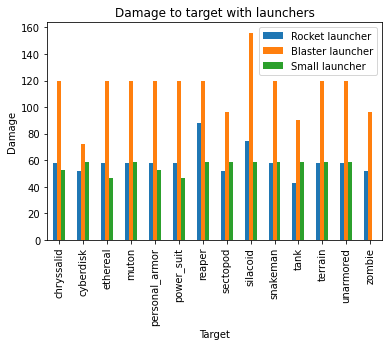

In [12]:
weapon_damages_targets_launcher = weapon_damages_targets.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_damages_targets_launcher = weapon_damages_targets_launcher.swaplevel().unstack()
weapon_damages_targets_launcher = weapon_damages_targets_launcher.sort_values(by=["target"])
ax = weapon_damages_targets_launcher.plot.bar(title="Damage to target with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Laser

Text(0, 0.5, 'Damage')

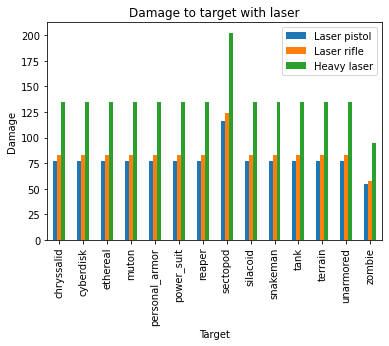

In [13]:
weapon_damages_targets_laser = weapon_damages_targets.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_damages_targets_laser = weapon_damages_targets_laser.swaplevel().unstack()
weapon_damages_targets_laser = weapon_damages_targets_laser.sort_values(by=["target"])
ax = weapon_damages_targets_laser.plot.bar(title="Damage to target with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Plasma

Text(0, 0.5, 'Damage')

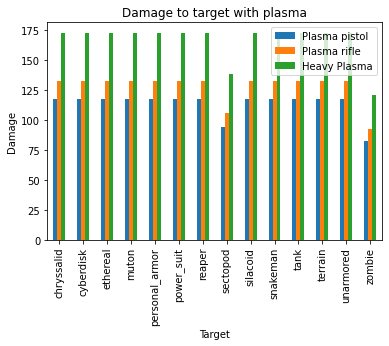

In [14]:
weapon_damages_targets_plasma = weapon_damages_targets.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_damages_targets_plasma = weapon_damages_targets_plasma.swaplevel().unstack()
weapon_damages_targets_plasma = weapon_damages_targets_plasma.sort_values(by=["target"])
ax = weapon_damages_targets_plasma.plot.bar(title="Damage to target with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Tank

Text(0, 0.5, 'Damage')

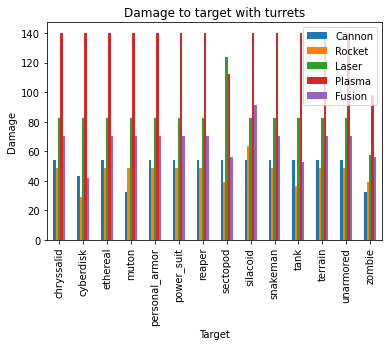

In [15]:
weapon_damages_targets_tank = weapon_damages_targets.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_damages_targets_tank = weapon_damages_targets_tank.swaplevel().unstack()
weapon_damages_targets_tank = weapon_damages_targets_tank.sort_values(by=["target"])
ax = weapon_damages_targets_tank.plot.bar(title="Damage to target with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Target Damage Lists

#### Averages

In [16]:
weapon_damages_average = weapon_damages_targets.groupby(["weapon"]).mean()
weapon_damages_average = weapon_damages_average.sort_values(by=["turn_damage"])

In [17]:
weapon_damages_max = weapon_damages_targets.groupby(["weapon"]).max()
weapon_damages_max = weapon_damages_max.sort_values(by=["turn_damage"])

In [18]:
average_damages_expected = weapon_damages_max.merge(weapon_damages_average, on="weapon")
average_damages_expected = average_damages_expected.rename(columns={"turn_damage_x": "max", "turn_damage_y": "average"})
average_damages_expected = average_damages_expected.sort_values(by=["average"])
average_damages_expected

,max,average
weapon,,
grenade,21.1250,15.379464
proximity_grenade,29.5750,21.531250
alien_grenade,38.0250,27.683036
rifle,36.0000,33.428571
high_explosive,46.4750,33.834821
pistol,39.0000,36.214286
rocket_turret,63.5375,46.256696
auto_cannon,78.3360,47.232000
cannon_turret,54.0000,50.142857


Text(0, 0.5, 'Damage')

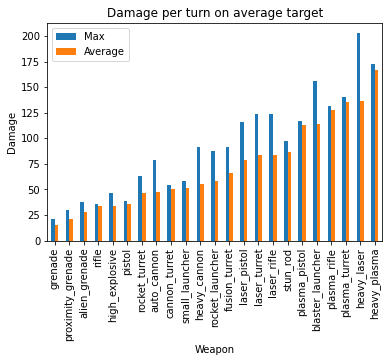

In [19]:
ax = average_damages_expected.plot.bar(title="Damage per turn on average target", legend=False)
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Terrain

In [20]:
weapon_damages_terrain = weapon_damages_targets.xs("terrain", level="target")
weapon_damages_terrain = weapon_damages_terrain.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

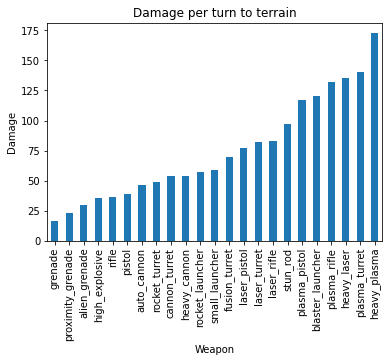

In [21]:
ax = weapon_damages_terrain.plot.bar(title="Damage per turn to terrain", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Unarmored

In [22]:
weapon_damages_unarmored = weapon_damages_targets.xs("unarmored", level="target")
weapon_damages_unarmored = weapon_damages_unarmored.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

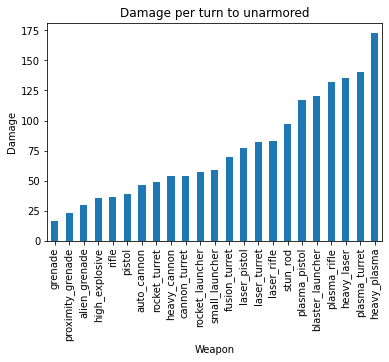

In [23]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to unarmored", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Personal Armor

In [24]:
weapon_damages_armor = weapon_damages_targets.xs("personal_armor", level="target")
weapon_damages_armor = weapon_damages_armor.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

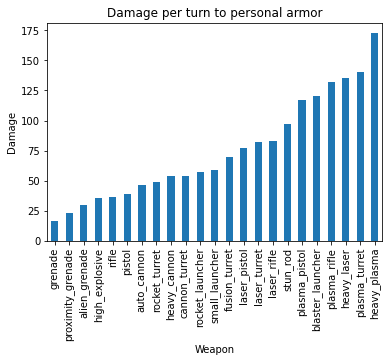

In [25]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to personal armor", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Power Suit

In [26]:
weapon_damages_power_suit = weapon_damages_targets.xs("power_suit", level="target")
weapon_damages_power_suit = weapon_damages_power_suit.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

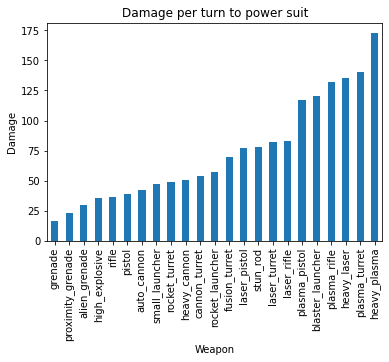

In [27]:
ax = weapon_damages_power_suit.plot.bar(title="Damage per turn to power suit", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Tank

In [28]:
weapon_damages_tank = weapon_damages_targets.xs("tank", level="target")
weapon_damages_tank = weapon_damages_tank.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

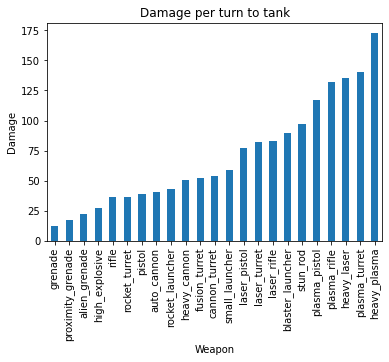

In [29]:
ax = weapon_damages_tank.plot.bar(title="Damage per turn to tank", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Snakeman

In [30]:
weapon_damages_snakeman = weapon_damages_targets.xs("snakeman", level="target")
weapon_damages_snakeman = weapon_damages_snakeman.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

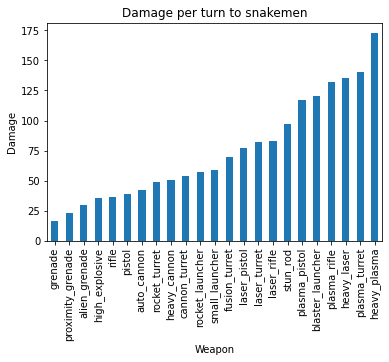

In [31]:
ax = weapon_damages_snakeman.plot.bar(title="Damage per turn to snakemen", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Ethereal

In [32]:
weapon_damages_ethereal = weapon_damages_targets.xs("ethereal", level="target")
weapon_damages_ethereal = weapon_damages_ethereal.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

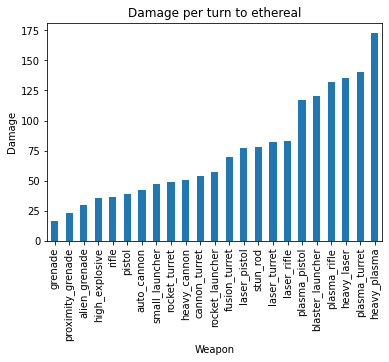

In [33]:
ax = weapon_damages_ethereal.plot.bar(title="Damage per turn to ethereal", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Muton

In [34]:
weapon_damages_muton = weapon_damages_targets.xs("muton", level="target")
weapon_damages_muton = weapon_damages_muton.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

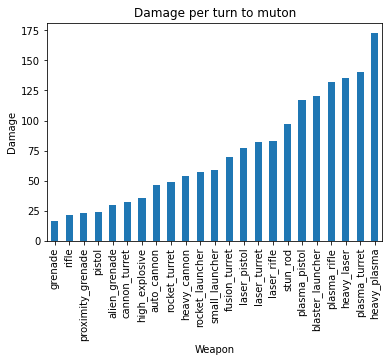

In [35]:
ax = weapon_damages_muton.plot.bar(title="Damage per turn to muton", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Silacoid

In [36]:
weapon_damages_silacoid = weapon_damages_targets.xs("silacoid", level="target")
weapon_damages_silacoid = weapon_damages_silacoid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

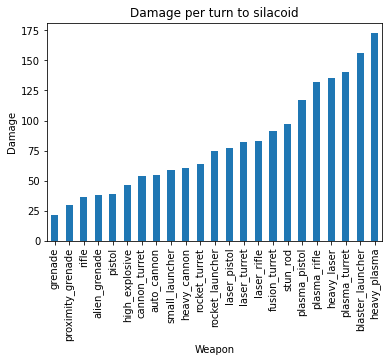

In [37]:
ax = weapon_damages_silacoid.plot.bar(title="Damage per turn to silacoid", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Chryssalid

In [38]:
weapon_damages_chryssalid = weapon_damages_targets.xs("chryssalid", level="target")
weapon_damages_chryssalid = weapon_damages_chryssalid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

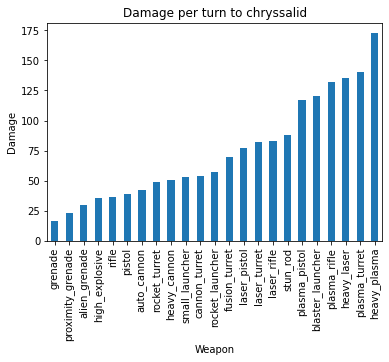

In [39]:
ax = weapon_damages_chryssalid.plot.bar(title="Damage per turn to chryssalid", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Reaper

In [40]:
weapon_damages_reaper = weapon_damages_targets.xs("reaper", level="target")
weapon_damages_reaper = weapon_damages_reaper.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

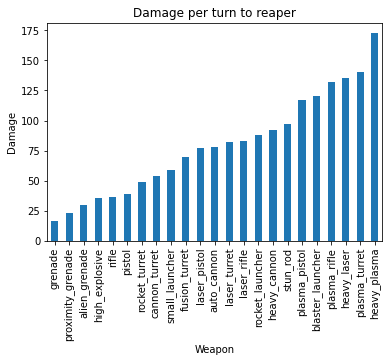

In [41]:
ax = weapon_damages_reaper.plot.bar(title="Damage per turn to reaper", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Sectopod

In [42]:
weapon_damages_sectopod = weapon_damages_targets.xs("sectopod", level="target")
weapon_damages_sectopod = weapon_damages_sectopod.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

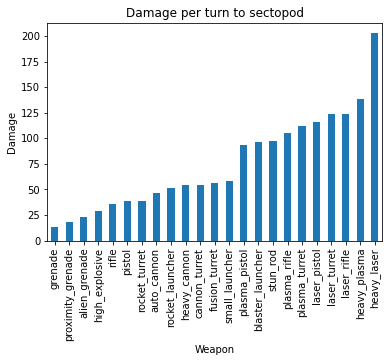

In [43]:
ax = weapon_damages_sectopod.plot.bar(title="Damage per turn to sectopod", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Cyberdisk

In [44]:
weapon_damages_cyberdisk = weapon_damages_targets.xs("cyberdisk", level="target")
weapon_damages_cyberdisk = weapon_damages_cyberdisk.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

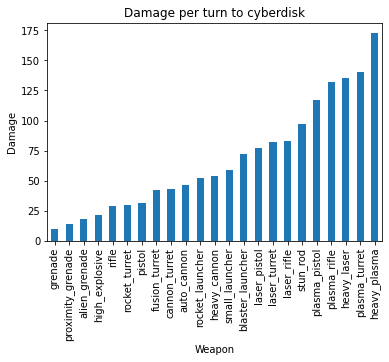

In [45]:
ax = weapon_damages_cyberdisk.plot.bar(title="Damage per turn to cyberdisk", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Zombie

In [46]:
weapon_damages_zombie = weapon_damages_targets.xs("zombie", level="target")
weapon_damages_zombie = weapon_damages_zombie.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

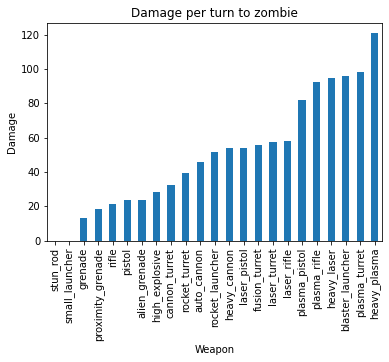

In [47]:
ax = weapon_damages_zombie.plot.bar(title="Damage per turn to zombie", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")